<span>
<img src="img/cdlib_new.png" width="120px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.7<br/>
<b>CDlib version:</b>  0.1.10<br/>
<b>Last update:</b> 16/02/2021
</span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

<a id='top'></a>
# *Chapter 11: Dynamic Community Discovery*

In this notebook are introduced the main steps for the extraction and topological analysis of communities from dynamic networks.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available in ``CDlib``, please refer to the official [documentation](https://cdlib.readthedocs.io) and the dedicated notebook appendix.

**Note 2:** Dynamic community support is still under development in ``CDlib``. To access it install the latest version of the library from the github repository with:

    !pip install git+https://github.com/GiulioRossetti/cdlib.git

## Table of Contents

1. [Community Discovery in Dynamic Networks](#workflow)
    1. [Instant Optimal: Identify & Match](#im)
    2. [Temporal Trade-off: Tiles](#tiles)

In [2]:
import cdlib

<a id='workflow'></a>
## Community Discovery in Dynamic Networks ([to top](#top))

In dynamic networks community structures evolves as time goes by.

In this notebook we will learn how to apply a dynamic community discovery algorithm (TILES) and how to adapt static ones to the dynamic topologies.
All analysis will be performed using ``CDlib``.

As a first step we need to define a dynamic network topology.

To such extent we will use the ``dynetx`` library (see Chapter 9).

In [3]:
import dynetx as dn
import networkx as nx

def read_net(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1])
    return g

<a id="im"></a>
## Instant Optimal: Identify & Match ([to top](#top))

The easiest way to design an Instant Optimal CD is to apply a same static algorithm to each network snapshot independently.

After that, snapshots' clusterings can be organized in a ``CDlib.TemporalClustering`` object.

As an example we are going to describe a simple Instant Optimal algorithm leveraging the Louvain algorithm.

In [4]:
from cdlib import algorithms, evaluation

In [5]:
from cdlib import TemporalClustering

tc = TemporalClustering()
for t in range(1,9):
    g = read_net(f"data/asioaf/got-s{t}-edges.csv")
    coms = algorithms.louvain(g)  # here any CDlib algorithm can be applied
    tc.add_clustering(coms, t)

After built the temporal clustering it is possible to inspect the available temporal ids of the stored clusterings...

In [6]:
tc.get_observation_ids()

[1, 2, 3, 4, 5, 6, 7, 8]

... and use them to access individual clusterings (thus allowing standard analyses as discussed in Chapter 8).

In [7]:
tc.get_clustering_at(1)

A simple measure of temporal stability is the clustering stability trend.

Given as input a TemporalClustering and a partition similarity score (e.g., NMI, NF1...) such a trend describe how much partitions tend to remain the same as time goes by.

In [8]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.21759259259259256,
 0.22222222222222224,
 0.11277777777777777,
 0.17857142857142858,
 0.20370370370370372,
 0.13222222222222224,
 0.2333333333333333]

Since our aim is to transform a static algorithm into a dinamic one, once computed the clusterings we have to match them across consecutive temporal ids.

We can check that our custom made approach does not came an explicit matching with...

In [9]:
tc.has_explicit_match()

False

... and define any similarity function (taking as input two sets and returning a float value) to perform such cross-temporal match.

In [10]:
jaccard = lambda x, y: len(set(x) & set(y)) / len(set(x) | set(y))

After that we can apply it to our temporal partition, specifying if it has to be applied only from past to future (one side) or even from future to past (two sided).

The former scenario allows to identify merging events, the latter also split ones.

In [11]:
matches = tc.community_matching(jaccard, two_sided=True)

In [12]:
f"Example of community match: {matches[0]}"

"Example of community match: ('1_0', '2_1', 0.23333333333333334)"

In [13]:
c1 = tc.get_clustering_at(1).named_communities[matches[0][0]]
c1

['NED',
 'ROBERT',
 'LITTLEFINGER',
 'VARYS',
 'ARYA',
 'CERSEI',
 'JOFFREY',
 'SANSA',
 'PYCELLE',
 'SEPTA_MORDANE',
 'LORAS',
 'RENLY',
 'SYRIO_FOREL',
 'JORY_CASSEL',
 'ROS',
 'BARRISTAN',
 'YOREN',
 'HOUND',
 'LANCEL',
 'JANOS',
 'GENDRY',
 'HOT_PIE',
 'LOMMY_GREENHANDS',
 'MERYN_TRANT',
 'JON_ARRYN',
 'STANNIS',
 'MYCAH',
 'TOBHO_MOTT',
 'MHAEGEN',
 'BAELOR',
 'STABLE_BOY',
 'HUGH_OF_THE_VALE',
 'MOUNTAIN',
 'TOMARD',
 'ILYN_PAYNE',
 'LYANNA',
 'BERIC',
 'HIGH_SEPTON',
 'TOMMEN',
 'MACE',
 'ROOSE_BOLTON',
 'STEFFON',
 'VARLY']

In [14]:
c2 = tc.get_clustering_at(2).named_communities[matches[0][1]]
c2

['CERSEI',
 'TYRION',
 'VARYS',
 'SHAE',
 'BRONN',
 'JOFFREY',
 'SANSA',
 'PYCELLE',
 'HOUND',
 'JANOS',
 'LANCEL',
 'PODRICK',
 'TOMMEN',
 'ROS',
 'DAISY',
 'DONTOS',
 'HAYLENE',
 'MERYN_TRANT',
 'MYRCELLA',
 'MANDON',
 'TIMETT',
 'BARRA',
 'MHAEGEN',
 'ILYN_PAYNE',
 'ROBIN',
 'BOROS',
 'JOANNA',
 'HIGH_SEPTON',
 'LYSA',
 'TRYSTANE',
 'PROTESTER']

In [15]:
set(c1) & set(c2)

{'CERSEI',
 'HIGH_SEPTON',
 'HOUND',
 'ILYN_PAYNE',
 'JANOS',
 'JOFFREY',
 'LANCEL',
 'MERYN_TRANT',
 'MHAEGEN',
 'PYCELLE',
 'ROS',
 'SANSA',
 'TOMMEN',
 'VARYS'}

In [16]:
jaccard(c1,c2)

0.23333333333333334

Once obtained the match among communities we can compute their lifecycle graph: a directed polytree representing community transformation across time.

In [17]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=False)

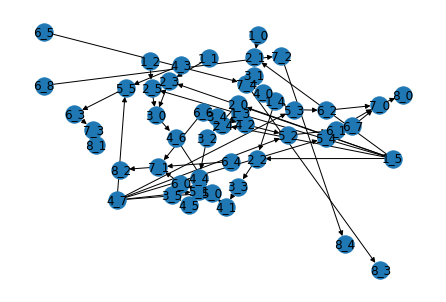

In [18]:
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True) 

<a id="times"></a>
## Temporal Trade-off: TILES ([to top](#top))

Another class of approaches to DCD involves the identification of dynamic communities avoiding the matching step, just incrementally computing them as the network topology evolves.

A method following such strategy is ``Tiles`` (which requires a parameter ``obs`` that specifies the temporal window width to use for observing temporal clusterings evolution).

In [19]:
dg = dn.DynGraph()
for x in range(1,9):
    g = read_net(f"data/asioaf/got-s{x}-edges.csv")
    dg.add_interactions_from(list(g.edges()), t=x)

In [20]:
tc = algorithms.tiles(dg, obs=1)

In [21]:
type(coms)

cdlib.classes.node_clustering.NodeClustering

In [22]:
tc.get_observation_ids()

[1, 2, 3, 4, 5, 6, 7, 8]

Identified clustering are not ``NodeClustering`` object but, instead, ``NamedClustering`` ones.

In [23]:
type(tc.get_clustering_at(2))

cdlib.classes.named_clustering.NamedClustering

This is because identified temporal communities are not independently named, rather their name is assigned in a way to track their evolution implicitly.

In [24]:
tc.get_clustering_at(2).named_communities.keys()

dict_keys(['2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '2_10', '2_11', '2_12', '2_13', '2_14', '2_15', '2_16', '2_17', '2_18', '2_19', '2_20', '2_21', '2_22', '2_23', '2_24', '2_25', '2_26', '2_27', '2_28', '2_29', '2_30', '2_31', '2_32', '2_33', '2_34', '2_35', '2_36', '2_37', '2_38', '2_39', '2_40', '2_41', '2_42', '2_43', '2_44', '2_45', '2_46', '2_47', '2_48', '2_49'])

This implies that if we check for explicit community match we are going to get something like this..

In [25]:
tc.has_explicit_match()

True

In [26]:
match = tc.get_explicit_community_match()

Apart for such difference w.r.t. Instant Optimal approach, we can perform the same analyses seen before

In [27]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.006923076923076923,
 0.0043820895522388055,
 0.0035339431872893593,
 0.0246505376344086,
 0.02858974358974359,
 0.051181988742964354,
 0.07392953929539298]

without the need of specifying a match function while building the lifecycle polytree

In [28]:
com_polytree = tc.lifecycle_polytree()

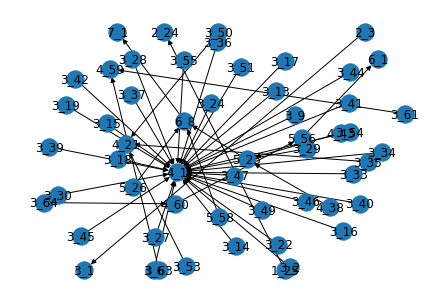

In [29]:
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True) 